In [1]:
from matplotlib import pyplot as plt
from IPython.display import display, clear_output

import re
import copy
import numpy as np
import torch

from collections import deque, namedtuple

import random

# Set the seed values
torch.seed = 1234
np.random.seed(torch.seed)
random.seed(torch.seed)


### GridWorld Environment

In [2]:
class GridWorld():
    def __init__(self, d=4, mode='static'):
        if d < 4:
            raise Exception("Minimum dimension should be equal to 4!")
        
        if mode not in ['static', 'player', 'random']:
            raise Exception("The mode should be either static, player or random.")
        self.mode = mode
        self.d = d
        # We set the max number of moves that can be played in a game
        self.maxMoves = self.d**3
        # Max reward positive or negative for win or loss
        self.artifacts = ['_', '|', '+', '-', 'P'] 
        self.artifactsMap = {'_': 0, '|': 1, '+': 2, '-': 3, 'P': 4}       
        self.rewardMap = {'_': -1, '+': 100, '-': -100}
        self.actionSpace = {'up': (-1, 0), 'right': (0, 1), 'down': (1, 0), 'left': (0, -1)}               
        
        # Initialize the environment
        _ = self.reset()


        # Set the params for rendering
        self.renderprops = {}
        self.renderprops['left'], self.renderprops['width'] = .25, .5
        self.renderprops['bottom'], self.renderprops['height'] = .25, .5
        self.renderprops['right'] = self.renderprops['left'] + self.renderprops['width']
        self.renderprops['top'] = self.renderprops['bottom'] + self.renderprops['height']

        self.renderprops['fig'], self.renderprops['ax'] = plt.subplots(figsize=(1,1))       
        # We dont want to show the figure at this point 
        plt.close()

    # Transform the grid to a multi-dimensional array
    def transformGrid(self):
        grid = []
        artifacts = ['|', '+', '-', 'P']
        for a in artifacts:
            plane = np.zeros_like(self.grid, dtype=np.int8)
            for b in artifacts:
                if a == b:
                    plane = np.where(self.grid == b, 1, plane)
            grid.append(plane)
        return np.array(grid)

    # Reset to initial state
    def reset(self):
        # Set the current move
        self.moveCount = 0
         # Create a empty grid with all places as open
        self.grid = np.tile(np.array(self.artifacts[0]), (self.d, self.d))

        # If the mode is static, set all positions as constant
        if self.mode == 'static':
            # Update the grid with wall, win, loss and player positons
            self.grid[2, 2] = self.artifacts[1] # Wall
            self.grid[0, 0] = self.artifacts[2] # Win
            self.grid[0, 3] = self.artifacts[3] # Loss
            self.grid[3, 2] = self.artifacts[4] # Player

            # record the player, win and loss locations
            self.wallPos = np.array([2, 2])
            self.winPos = np.array([0, 0])
            self.lossPos = np.array([0, 3])
            self.playerPos = np.array([3, 2])
        # If mode is player, set the player position to random
        elif self.mode == 'player':
            # Update the grid with wall, win and loss locations
            self.grid[2, 2] = self.artifacts[1] # Wall
            self.grid[0, 0] = self.artifacts[2] # Win
            self.grid[0, 3] = self.artifacts[3] # Loss

            # record the win and loss locations    
            self.wallPos = np.array([2, 2])        
            self.winPos = np.array([0, 0])
            self.lossPos = np.array([0, 3])

            # Set the playerPos to random            
            self.playerPos = np.random.choice(self.d, size=2)            
            # Ensure that the player position is not the same as the win, loss and wall positions
            while (self.playerPos == self.winPos).all() or (self.playerPos == self.lossPos).all() or (self.playerPos == self.wallPos).all():
                self.playerPos = np.random.choice(self.d, size=2)
            
            # Update the grid with the player position
            self.grid[self.playerPos[0], self.playerPos[1]] = self.artifacts[4] # Player            
        else:
            # Set the playerPos to random            
            self.playerPos = np.random.choice(self.d, size=2)  
            
            # Set the winPos to random
            self.winPos = np.random.choice(self.d, size=2)  
            # Ensure that the win position is not the same as the player position
            while (self.winPos == self.playerPos).all():
                self.winPos = np.random.choice(self.d, size=2)

            # Set the lossPos to random
            self.lossPos = np.random.choice(self.d, size=2)  
            # Ensure that the loss position is not the same as the player or win position
            while (self.lossPos == self.playerPos).all() or (self.lossPos == self.winPos).all():
                self.lossPos = np.random.choice(self.d, size=2)
            
            # Set the wallPoss to random
            self.wallPos = np.random.choice(self.d, size=2)  
            # Ensure that the wall position is not the same as the player or win or loss position
            while (self.wallPos == self.playerPos).all() or (self.wallPos == self.winPos).all() or (self.wallPos == self.lossPos).all():
                self.wallPos = np.random.choice(self.d, size=2)
            
            # Update the grid with the positions
            self.grid[self.wallPos[0], self.wallPos[1]] = self.artifacts[1] # Wall
            self.grid[self.winPos[0], self.winPos[1]] = self.artifacts[2] # Win
            self.grid[self.lossPos[0], self.lossPos[1]] = self.artifacts[3] # Loss
            self.grid[self.playerPos[0], self.playerPos[1]] = self.artifacts[4] # Player

        return self.transformGrid().flatten()

    # Perform an action, modify the state, get the new state, reward and status information
    def step(self, action):
        if action not in self.actionSpace.keys():
            raise Exception('Action not present in action space')

        # Increment the moveCount
        self.moveCount += 1
        info = ''
        # Check if its already game over.
        done = True if (self.playerPos == self.winPos).all() or (self.playerPos == self.lossPos).all() else False
        reward = -1

        x, y = copy.copy(self.playerPos) + self.actionSpace[action]
        if self.moveCount < self.maxMoves:
            if  not done:                                    
                # Check that we are not at the edges
                if x >= 0 and x < self.d and y >= 0 and y < self.d:
                    # We allow the player to transition to the new position if the new postion doesnot contain a wall
                    if self.grid[x, y] != '|':
                        # record the reward the player will receive after transitioning to this new position
                        reward = self.rewardMap[self.grid[x, y]]
                        # Check if its game won or over
                        if self.grid[x, y] == '+' or self.grid[x, y] == '-':
                            done = True
                        # Update the grid with this new transition                             
                        self.grid[x, y] = 'P'
                        self.grid[self.playerPos[0], self.playerPos[1]] = '_'
                        
                        # Update the player position
                        self.playerPos = np.array([x, y])
        else:
            done = True

        # Return the next state, reward received, is done flag and any other info                
        return self.transformGrid().flatten(), reward, done, info

    # Renders the game to the screen
    def render(self):
        self.renderprops['ax'].cla()
        self.renderprops['ax'].axis('off')
        self.renderprops['ax'].text(0.5*(self.renderprops['left']+self.renderprops['right']), 0.5*(self.renderprops['bottom']+self.renderprops['top']), re.sub("[\'\[\]]", '', np.array2string(self.grid)),
            horizontalalignment='center',
            verticalalignment='center',
            fontsize=20, color='red')        
        display(self.renderprops['fig'])

        clear_output(wait = True)
        plt.pause(0.5)

### GridWorld Agent

In [38]:
import torch
from torch import nn, optim
class Agent():
    def __init__(self, envDimension=4, learningRate=1e-3, gamma=0.9, maxEpsilon = 1, minEpsilon=0.1, device='cpu'):
        # Store the params
        self.device = device
        self.envDimension = envDimension
        self.learningRate = learningRate
        self.gamma = gamma
        self.maxEpsilon = maxEpsilon
        self.minEpsilon = minEpsilon
        # Get the available list of actions that can be performed in the game
        self.availableActions = list(GridWorld(self.envDimension, mode='static').actionSpace.keys())
                        
    
    def createModel(self):        
        model = torch.nn.Sequential(
        # Input -> Hidden1
        torch.nn.Linear(64, 150),
        torch.nn.ReLU(),
        # Hidden1 -> Hidden2
        torch.nn.Linear(150, 100),
        torch.nn.ReLU(),
        # Hidden2 -> Output
        torch.nn.Linear(100, 4))

        # Add the model
        self.model = model.to(self.device)
        # We also create copy of the model as a target model. We use it if OET algo is used
        self.targetmodel = copy.deepcopy(self.model)
        self.targetmodel.load_state_dict(self.model.state_dict())
        
        return self.model, optim.Adam(model.parameters(), lr = self.learningRate), nn.MSELoss()

    def backward(self, loss, optimizer):
        # Backprop                    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    def train(self, algo, mode='static', epochs=1000, memSize=1000, batchSize=200, syncFreq=500):                 
        if algo.upper() not in ['Q', 'QE', 'QET']:            
            raise Exception('The algorithm used for training should be Q: for Q Learning, QE: for Experiance Replay and QET: for Experiance Replay with a Target Network')
        # Create the model to train
        model, optimizer, lossfun = self.createModel()
        # Set the epsilon value
        epsilon = self.maxEpsilon
        # Store the losses. We will plot it later
        losses = []
        # Named tuple to store the experiences if we are using experiance replay
        Experience = namedtuple('buffer', field_names=['state', 'action', 'reward', 'done', 'nextState'])
        # We also need a replay buffer for experiance replay
        replay = deque(maxlen=memSize)

        # The sync of params to the target network is controlled via a variable. Will be used only if QET algo is applied
        targetNetworkSyncController = 0
        for e in range(epochs):            
            # Instantiate the environment for the current epoch
            env = GridWorld(self.envDimension, mode=mode)
            # Reset the environment and convert it to a tensor.
            state = torch.from_numpy(env.reset()).to(self.device).float()

            # Set the game status to not done
            done = False            
            # Play until the game doesnot end
            while not done:
                targetNetworkSyncController += 1
                Q = model(state)
                Q_ = Q.data.cpu().numpy()
                action_ = ""
                if(np.random.random() < epsilon):
                    # Choose one of the valid options            
                    action_ = np.random.choice(len(self.availableActions))
                else:                                     
                    action_ = np.argmax(Q_)

                # Step through the environment
                nextState_, reward, done, _ = env.step(self.availableActions[action_])
                # Evaluate the Q Vals for the next state
                nextState = torch.from_numpy(nextState_).to(self.device).float()
                
                # Add to memory, will be used only if we are using QE or QET algo
                replay.append(Experience(state, action_, reward, done, nextState))

                state = nextState
                if algo in ['QE', 'QET']:
                    if len(replay) > batchSize:
                        miniBatchIndices = np.random.choice(len(replay), batchSize, replace=False)                                                                                              
                        stateBatch = torch.stack([ replay[idx].state  for idx in miniBatchIndices]).to(self.device)
                        actionBatch = torch.Tensor([ replay[idx].action  for idx in miniBatchIndices]).to(self.device)        
                        rewardBatch = torch.Tensor([ replay[idx].reward  for idx in miniBatchIndices]).to(self.device)                        
                        doneBatch = torch.Tensor([ replay[idx].done  for idx in miniBatchIndices]).to(self.device)
                        nextStateBatch = torch.stack([ replay[idx].nextState  for idx in miniBatchIndices]).to(self.device)                   
                        
                        QExp = model(stateBatch)  
                        
                        nextQExp = None
                        if algo == 'QE': # If only experiance replay is used
                            with torch.no_grad():
                                nextQExp = model(nextStateBatch)
                        else: # If experiance replay with a target network is used (QET)
                            with torch.no_grad():
                                # We use the target network to get the maximum Q value for the next state
                                nextQExp = self.targetmodel(nextStateBatch) 
                        
                        # Expected State Action Value                        
                        YHat = rewardBatch + self.gamma * ((1 - doneBatch) * torch.max(nextQExp, dim=1)[0])                        
                        
                        # Current State Action Value
                        Y = QExp.gather(dim=1, index=actionBatch.long().unsqueeze(dim=1)).squeeze()
                        
                        # Backprop
                        loss = lossfun(Y, YHat)
                        losses.append(loss.item())
                        self.backward(loss, optimizer)       

                        # Copies the main model parameters to the target network
                        if targetNetworkSyncController % syncFreq == 0:
                            self.targetmodel.load_state_dict(self.model.state_dict())                                 
                else: # IF we are using Q algo
                    with torch.no_grad():
                        nextQ = model(nextState)                        

                    # Max state action value we will receive if the choosen action is taken in the current step
                    maxNextQ = torch.max(nextQ)                    

                    # Estimated future rewards
                    if not done:
                        YHat = reward + (self.gamma * maxNextQ)
                    else:
                        YHat = reward
                    
                    YHat = torch.Tensor([YHat]).detach().to(self.device)                                       

                    # Current state action value
                    Y = Q.squeeze()[action_]            
                                
                    # Backprop
                    loss = lossfun(Y, YHat)
                    losses.append(loss.item())
                    self.backward(loss, optimizer,)                                    
                             
            # Adapt the epsilon value
            if epsilon > self.minEpsilon:
                epsilon -= (1/1000)        

            # Print the progress
            if e % np.round(epochs/10) == 0:       
                error = np.mean(losses)
                print('epoch: {:d}, error: {:.2f}'.format(e, error))
        plt.plot(losses)

    # A function to test the trained model
    def test(self, numGames=10, mode='static', display=False):
        # Number of games to test on    
        numWins = 0
        numLoss = 0

        for g in range(numGames):        
            # Testing
            testEnv = GridWorld(4, mode=mode)        
            state = torch.from_numpy(testEnv.reset()).to(self.device).float()
                        
            m = 0        
            done = False
            maxMoves = 10
            while not done and maxMoves > 0:
                maxMoves -= 1
                Q = self.model(state)
                Q_ = Q.data.cpu().numpy()                        
                # Set the invalid actions qval to neg. inf.                               
                action_ = np.argmax(Q_)    
                action = self.availableActions[action_]
                
                nextState_, reward, done, _ = testEnv.step(action)    
                state = torch.from_numpy(nextState_).to(self.device).float()
                
                m += 1         
                
                if display: # Render the moves to screen
                    testEnv.render() # Render it
                else:# If rendering is off, we print some status
                    print('GAME: {}. Move #: {}; Took action: {}; Reward received: {}'.format(g+1, m, action, reward))                    
                
                if done:                
                    # If the end reward is 100, we have a win
                    if reward == 100:
                        numWins += 1
                    if reward == -100:
                        numLoss += 1
            
        print('Total games played={}. Of which {} are won, {} are lost, and {} were abandoned'.format(numGames, numWins, numLoss, numGames - numWins - numLoss))

In [39]:
# Check if you have a GPU and that cuda is configured
isGPU = torch.cuda.is_available()
print('Is CUDA present:', isGPU)
if isGPU:
    print('If you would like to use the GPU, pass the param device="cuda" to your Agent constructor')

Is CUDA present: True
If you would like to use the GPU, pass the param device="cuda" to your Agent constructor


### Q-Learning

C:\Users\chakr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch: 0, error: 419.55
epoch: 100, error: 260.26
epoch: 200, error: 196.91
epoch: 300, error: 173.24
epoch: 400, error: 158.29
epoch: 500, error: 144.86
epoch: 600, error: 134.25
epoch: 700, error: 124.21
epoch: 800, error: 117.14
epoch: 900, error: 111.67


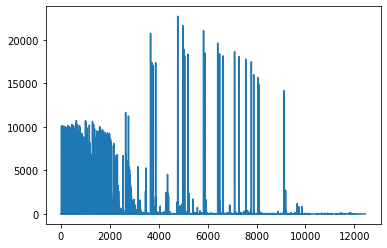

In [40]:
# Create the agent
agent = Agent()
# Train the agent
agent.train(algo='Q')

In [42]:
# Test on static mode
agent.test(numGames=1, display=True)

Total games played=1. Of which 1 are won, 0 are lost, and 0 were abandoned


In [43]:
# Test on player mode
agent.test(numGames=10, mode='player', display=True)

Total games played=10. Of which 10 are won, 0 are lost, and 0 were abandoned


In [44]:
# Test on random mode
agent.test(numGames=10, mode='random', display=True)

Total games played=10. Of which 1 are won, 0 are lost, and 9 were abandoned


### Q-Learning with Experience Replay

In [45]:
# Create the agent
agent = Agent(minEpsilon=0.01, device='cuda')
# Train the agent
agent.train(algo='QE', mode='random', epochs=5000, memSize=1000, batchSize=200)

C:\Users\chakr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\chakr\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\numpy\core\_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


epoch: 0, error: nan
epoch: 500, error: 85.95
epoch: 1000, error: 47.35
epoch: 1500, error: 36.46
epoch: 2000, error: 32.15


KeyboardInterrupt: 

<Figure size 72x72 with 0 Axes>

In [48]:
# Test on static mode
agent.test(numGames=1, display=True)

Total games played=1. Of which 1 are won, 0 are lost, and 0 were abandoned


In [49]:
# Test on player mode
agent.test(numGames=10, mode='player', display=False)

GAME: 1. Move #: 1; Took action: left; Reward received: -1
GAME: 1. Move #: 2; Took action: left; Reward received: -1
GAME: 1. Move #: 3; Took action: up; Reward received: -1
GAME: 1. Move #: 4; Took action: up; Reward received: -1
GAME: 1. Move #: 5; Took action: up; Reward received: -1
GAME: 1. Move #: 6; Took action: left; Reward received: 100
GAME: 2. Move #: 1; Took action: up; Reward received: -1
GAME: 2. Move #: 2; Took action: up; Reward received: -1
GAME: 2. Move #: 3; Took action: left; Reward received: 100
GAME: 3. Move #: 1; Took action: left; Reward received: 100
GAME: 4. Move #: 1; Took action: up; Reward received: -1
GAME: 4. Move #: 2; Took action: left; Reward received: 100
GAME: 5. Move #: 1; Took action: up; Reward received: -1
GAME: 5. Move #: 2; Took action: left; Reward received: 100
GAME: 6. Move #: 1; Took action: left; Reward received: 100
GAME: 7. Move #: 1; Took action: left; Reward received: -1
GAME: 7. Move #: 2; Took action: left; Reward received: -1
GAME:

In [50]:
# Test on random mode
agent.test(numGames=10, mode='random', display=True)

Total games played=10. Of which 9 are won, 0 are lost, and 1 were abandoned


### Q-Learning with Experience Replay and a Target Network

epoch: 0, error: nan
epoch: 500, error: 69.24
epoch: 1000, error: 65.41
epoch: 1500, error: 52.67
epoch: 2000, error: 49.15
epoch: 2500, error: 46.66
epoch: 3000, error: 45.23
epoch: 3500, error: 44.02
epoch: 4000, error: 43.14
epoch: 4500, error: 42.62


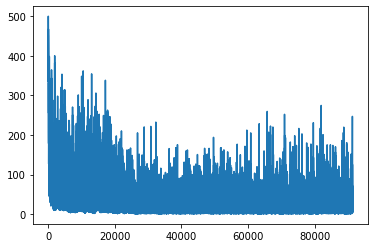

In [51]:
# Create the agent
agent = Agent(minEpsilon=0.01, device='cuda')
# Train the agent
agent.train(algo='QET', mode='random', epochs=5000, memSize=1000, batchSize=200, syncFreq=500)

In [52]:
# Test on static mode
agent.test(numGames=1, display=True)

Total games played=1. Of which 1 are won, 0 are lost, and 0 were abandoned


In [53]:
# Test on player mode
agent.test(numGames=10, mode='player', display=False)

GAME: 1. Move #: 1; Took action: up; Reward received: -1
GAME: 1. Move #: 2; Took action: up; Reward received: -1
GAME: 1. Move #: 3; Took action: up; Reward received: 100
GAME: 2. Move #: 1; Took action: left; Reward received: 100
GAME: 3. Move #: 1; Took action: up; Reward received: -1
GAME: 3. Move #: 2; Took action: left; Reward received: -1
GAME: 3. Move #: 3; Took action: left; Reward received: -1
GAME: 3. Move #: 4; Took action: left; Reward received: -1
GAME: 3. Move #: 5; Took action: up; Reward received: 100
GAME: 4. Move #: 1; Took action: left; Reward received: 100
GAME: 5. Move #: 1; Took action: left; Reward received: -1
GAME: 5. Move #: 2; Took action: left; Reward received: -1
GAME: 5. Move #: 3; Took action: left; Reward received: -1
GAME: 5. Move #: 4; Took action: up; Reward received: -1
GAME: 5. Move #: 5; Took action: up; Reward received: -1
GAME: 5. Move #: 6; Took action: up; Reward received: 100
GAME: 6. Move #: 1; Took action: up; Reward received: -1
GAME: 6. M

In [54]:
# Test on random mode
agent.test(numGames=25, mode='random', display=True)

Total games played=25. Of which 20 are won, 1 are lost, and 4 were abandoned
